# Проект e-commerce

In [ ]:
Импортируем библиотеки

In [239]:
import pandas as pd
from urllib.parse import urlencode
import requests
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import calendar as cl
from datetime import timedelta
%matplotlib inline
import plotly.express as px

Считываем таблицы

In [263]:
# внешняя ссылка на таблицу
df_url = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Получаем загрузочную ссылку
df_final_url = base_url + urlencode(dict(public_key=df_url))
response = requests.get(df_final_url)
df_download_url = response.json()['href']


customer = pd.read_csv(df_download_url, sep=",")

# внешняя ссылка на таблицу
df_url = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Получаем загрузочную ссылку
df_final_url = base_url + urlencode(dict(public_key=df_url))
response = requests.get(df_final_url)
df_download_url = response.json()['href']

orders = pd.read_csv(df_download_url, sep=",")

# внешняя ссылка на таблицу
df_url = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Получаем загрузочную ссылку
df_final_url = base_url + urlencode(dict(public_key=df_url))
response = requests.get(df_final_url)
df_download_url = response.json()['href']

order_items = pd.read_csv(df_download_url, sep=",")

Проверим данные, смерджим три таблицы в одну для проведения проверки

Для начала посмотрим типы данных

In [7]:
orders_items=customer.merge(orders, on='customer_id', how='left').merge(order_items, on='order_id', how='left')

In [8]:
orders_items.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
dtype: object

Как мы видим, столбцы с датами представлены в формате object, в проследствии придется переводить их в формат даты

Теперь посмотрим на количество пропущенных значений в колонках

In [9]:
orders_items.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
dtype: int64

Судя по пропущенным значениям в колонках order_approved_at, order_delivered_carrier_date, order_delivered_customer_date можно сделать вывод о том, что не все заказы были завершены. Также мы видим много пропусков в данных с товарами, но это связано с тем, что мы применили мердж с параметром how='left' и не все заказы содержали данные о товарах. Если мы проверим таблицу order_items отдельно, обнаружим, что пропущенных значений в ней нет.

In [10]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Проверим данные на дубликаты.

In [12]:
orders_items.loc[orders_items.duplicated()] 

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


Дубликаты отсутствуют.

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Покупкой можно считать как момент приобретения товара, так и момент его доставки (это определяется в соответствии с договором между продавцом и покупателем). 
Так как мы производим анализ для целей бизнеса (а не, например, отчет для налоговой), предлагаю не опираться на налоговый, гражданский кодексы или иные нормативные акты.
Для нас важно использовать полный объем данных о продажах, а не ограничиваться только доставленными заказами. Если клиент прошел все этапы воронки продаж и дошел до оплаты, то мы должны считать его своим покупателем и учитывать его действия в изучении покупок.

Поэтому предлагаю использовать для анализа заказы со временем подтверждения оплаты и считать их покупками.

Мерджим датафрейм для работы, который будет содержать информацию о пользователях и заказах

In [214]:
customer_orders=customer.merge(orders, on='customer_id', how='left')

Оставляем только оплаченные заказы

In [215]:
customer_orders = customer_orders.dropna(subset=['order_approved_at'])

Посмотрим, нет ли противоречий в данных и выведем статусы заказов.

In [216]:
customer_orders.groupby('order_status', as_index = False)\
    .agg({'order_id':'count'})

,order_status,order_id
0,approved,2
1,canceled,484
2,delivered,96464
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


Заказы со статусом approved (подтверждён) не могут быть оплачены, так как еще не был выставлен счет.
Предлагаю их исключить из покупок, так как данные по ним (либо статус, либо время оплаты) являются ошибкой.
Группируем по покупателям и находим только тех, кто совершил одну покупку.

In [210]:
customer_orders.query('order_status != "approved"') \
    .groupby('customer_unique_id', as_index = False)\
    .agg({'order_id':'count'}).query('order_id==1').count().order_id

93047

93047 пользователей совершили только 1 покупку

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Мерджим датафрейм для работы, который будет содержать информацию о пользователях и заказах

In [86]:
customer_orders=customer.merge(orders, on='customer_id', how='left')

Приводим колонку со временем оформления заказа к формату даты и оставляем только месяц и год

In [83]:
customer_orders.order_purchase_timestamp = pd.to_datetime(customer_orders.order_purchase_timestamp).dt.strftime('%Y-%m')

Создаем датафрейм с недоставленными заказами

In [84]:
orders_no_delivered = customer_orders.query('order_status != "delivered"')

Группируем данные, чтобы получить датафрейм со статусами заказов (причинами) и средним количеством заказов в меясяц. 
Также для удобства переименовываем колонки

In [64]:
orders_no_delivered.groupby(['order_purchase_timestamp','order_status'],as_index = False).agg({'customer_id':'count'}) \
    .groupby('order_status',as_index = False).agg({'customer_id':'mean'}) \
    .rename(columns={'customer_id':'orders_mean'}).round(0)

,order_status,orders_mean
0,approved,1.0
1,canceled,26.0
2,created,2.0
3,invoiced,15.0
4,processing,16.0
5,shipped,48.0
6,unavailable,29.0


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Мерджим датафрейм для работы, который будет содержать информацию о заказах и товарах

In [141]:
orders_items_time=orders.merge(order_items, on='order_id', how='left')

Приводим колонку со временем оформления заказа к формату даты и оставляем только неделю

In [142]:
orders_items_time.order_purchase_timestamp = pd.to_datetime(orders_items_time.order_purchase_timestamp).dt.strftime('%A')

Группируем данные о покупках по продуктам дням недели, подсчитав количество заказов, сортируем по убыванию и удаляем дубли продуктов за исключением самого часто повторяющегося

In [143]:
popular_day_of_the_week = orders_items_time.dropna(subset=['order_approved_at']) \
    .query('order_status != "approved"') \
    .groupby(['product_id','order_purchase_timestamp'], as_index=False).agg({'order_id':'count'}).sort_values('order_id', ascending=False) \
    .drop_duplicates(subset=["product_id"], keep='first')

Оставляем в датайфейме только нужные столбцы и переименовываем их

In [144]:
popular_day_of_the_week[{'product_id','order_purchase_timestamp'}].rename(columns={'order_purchase_timestamp':'frequently_day_of_the_week'})

,product_id,frequently_day_of_the_week
15899,422879e10f46682990de24d770e7f83d,Wednesday
36507,99a4788cb24856965c36a24e339b6058,Monday
41039,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday
20123,53b36df67ebb7c41585e8d54d6772e08,Tuesday
12995,368c6c730842d78016ad823897a372db,Friday
...,...,...
24004,642247ccf62585635cefa1bf09f59b94,Sunday
24016,642e125cbc752b4eeb8faf442319c39f,Thursday
24024,6432d844f2be41bb6f2fd279e23415da,Friday
24026,6435535083cf42eb1ce5d96f2c4d3482,Tuesday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

Мерджим датафрейм для работы, который будет содержать информацию о заказах, товарах и покупателях

Оставляем только нужные нам колонки и только оплаченные заказы

In [146]:
customer_items=customer.merge(orders, on='customer_id', how='left').merge(order_items, on='order_id', how='left') \
    .dropna(subset=['order_approved_at']) \
    .query('order_status != "approved"') \
    [{'customer_unique_id','order_id','order_purchase_timestamp','order_status'}]

Приводим колонку со временем оформления заказа к формату даты

In [147]:
customer_items.order_purchase_timestamp = pd.to_datetime(customer_items.order_purchase_timestamp)

Создаем колонку на основании даты с оформлением заказа с количеством недель в месяце

In [148]:
customer_items['week_in_mounth'] = customer_items.order_purchase_timestamp.dt.days_in_month/7

В колонке с датой оформления заказа оставляем только название месяца 

In [149]:
customer_items.order_purchase_timestamp = customer_items.order_purchase_timestamp.dt.month_name()
customer_items.head(5)

,customer_unique_id,order_id,order_purchase_timestamp,order_status,week_in_mounth
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,May,delivered,4.428571
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,January,delivered,4.428571
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,May,delivered,4.428571
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,March,delivered,4.428571
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,July,delivered,4.428571
...,...,...,...,...,...
113420,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,April,delivered,4.285714
113421,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,April,delivered,4.285714
113422,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,April,delivered,4.285714
113423,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,November,delivered,4.285714


Производим группировку по покупателю, месяцу покупки и данными о количестве недель в этом меясце, а также подсчитываем количество заказов. Удаляем пропущенные значения

In [25]:
customer_items = customer_items.groupby(['customer_unique_id','order_purchase_timestamp','week_in_mounth'], as_index = False).agg({'order_id':'count'}) \
    .groupby(['customer_unique_id','order_purchase_timestamp','week_in_mounth'], as_index = False).agg({'order_id':'sum'}).dropna()

Добавляем столбец со средним значением покупок в неделю по месяцам

In [26]:
customer_items['avg_purchase_in_week'] = pd.to_numeric(customer_items.order_id) / customer_items.week_in_mounth
customer_items.head(5)

,customer_unique_id,order_purchase_timestamp,week_in_mounth,order_id,avg_purchase_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,March,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1,0.233333
...,...,...,...,...,...
97996,fffcf5a5ff07b0908bd4e2dbc735a684,June,4.285714,2,0.466667
97997,fffea47cd6d3cc0a88bd621562a9d061,December,4.428571,1,0.225806
97998,ffff371b4d645b6ecea244b27531430a,February,4.000000,1,0.250000
97999,ffff5962728ec6157033ef9805bacc48,May,4.428571,1,0.225806


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

Метрика Retention означает «удержание пользователей» или же «возвращаемость пользователей».

Чтобы рассчитать Retention, вам нужно знать динамику количества активных пользователей определенной когорты по месяцам

Например:

Взять число новых пользователей в Month 0 (месяц первой покупки нашим покупателем);

Взять число активных пользователей в Month N (третий месяц после первой покупки Retention);

Разделить второе значение на первое, и результат умножить на 100.

Month N Retention = (Users Month N / Users Month 0) * 100

Мерджим датафрейм для работы, который будет содержать информацию о заказах и покупателях

И оставляем только оплаченные заказы с корректными статусами

In [241]:
customer_orders=customer.merge(orders, on='customer_id', how='left') \
    .dropna(subset=['order_approved_at']) \
    .query('order_status != "approved"') \
    .dropna(axis='index', how='any', subset=['order_purchase_timestamp'])
customer_orders.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


Приводим колонку со временем оформления заказа к формату даты и оставляем только год-месяц

In [242]:
customer_orders.order_purchase_timestamp = pd.to_datetime(customer_orders.order_purchase_timestamp).dt.strftime('%Y-%m')

Проверим период, за который были предоставлены данные

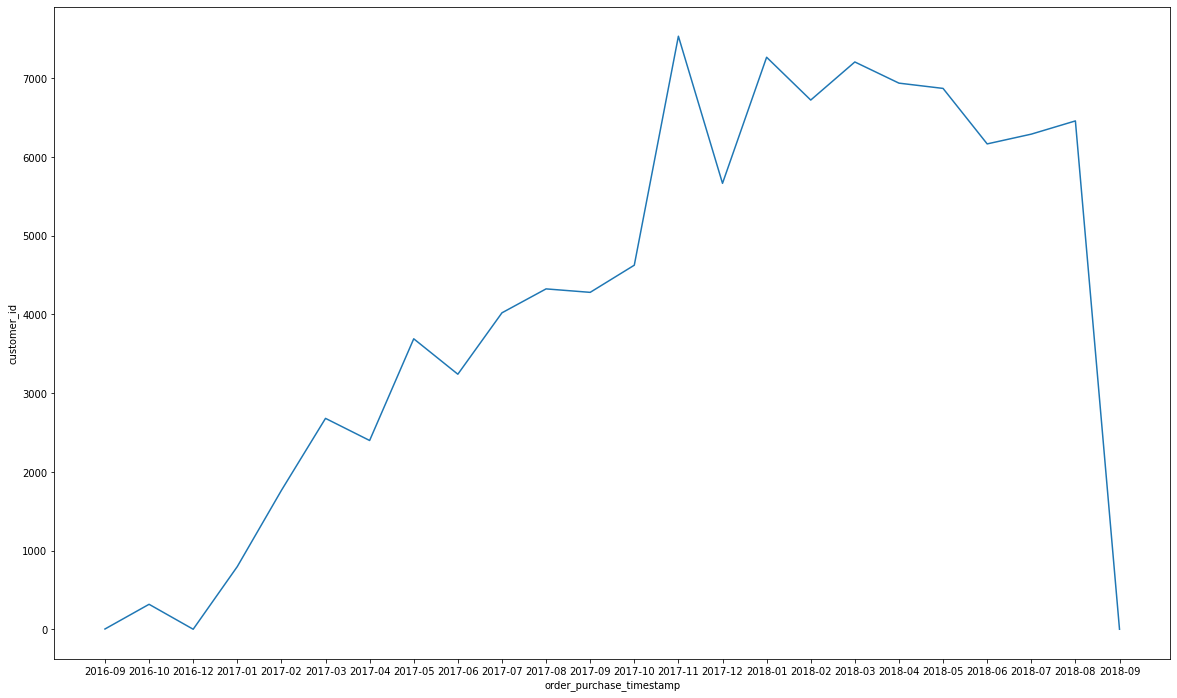

In [243]:
Peruiod = customer_orders.groupby('order_purchase_timestamp',as_index=False).agg({'customer_id':'count'})
line,ax = plt.subplots(figsize=(20,12))
sns.lineplot(data=Peruiod, x='order_purchase_timestamp', y='customer_id')

Т.к. в задании необходимо выявить когорту с января по декабрь, для анализа мы можем использовать только 2017, потому что 2016 и 2018 гг. не содержат необходимых для расчета полных данных.

Создадим столбец с месяцем первого заказа 'order_purchase_timestamp_first'

Для этого сгруппируем данные по уникальным id покупателей, выберем самые ранние даты покупок, вмерджим результат в основную таблицу и сменим названия колонок

In [244]:
customer_orders =customer_orders.groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'min'}) \
    .merge(customer_orders, on='customer_unique_id', how='right') \
    .rename(columns={'order_purchase_timestamp_x':'order_purchase_timestamp_first','order_purchase_timestamp_y':'order_purchase_timestamp'})

In [245]:
customer_orders.head(3)

,customer_unique_id,order_purchase_timestamp_first,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,861eff4711a542e4b93843c6dd7febb0,2017-05,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,290c77bc529b7ac935b93aa66c333dc3,2018-01,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05,4e7b3e00288586ebd08712fdd0374a03,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00


Оставим только нужные для расчета колонки 

In [246]:
customer_orders = customer_orders[{'customer_unique_id','order_purchase_timestamp_first','order_purchase_timestamp'}]

In [247]:
customer_orders.head(5)

,customer_unique_id,order_purchase_timestamp,order_purchase_timestamp_first
0,861eff4711a542e4b93843c6dd7febb0,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,2018-07,2018-07
...,...,...,...
99274,1a29b476fee25c95fbafc67c5ac95cf8,2018-04,2018-04
99275,d52a67c98be1cf6a5c84435bd38d095d,2018-04,2018-04
99276,e9f50caf99f032f0bf3c55141f019d99,2018-04,2018-04
99277,73c2643a0a458b49f58cea58833b192e,2017-11,2017-11


Определим общее кол-во пользователей, совершивших покупку по месяцам и добавим этот столбец к таблице с предыдущего шага

In [248]:
general_user=customer_orders.groupby('order_purchase_timestamp_first', as_index=False)  \
                    .agg({'customer_unique_id':'nunique'})  \
                    .rename(columns={'customer_unique_id':'general_user'})
customer_orders=customer_orders.merge(general_user, how='left', on='order_purchase_timestamp_first')

In [249]:
customer_orders.head(5)

,customer_unique_id,order_purchase_timestamp,order_purchase_timestamp_first,general_user
0,861eff4711a542e4b93843c6dd7febb0,2017-05,2017-05,3590
1,290c77bc529b7ac935b93aa66c333dc3,2018-01,2018-01,7024
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05,2018-05,6621
3,259dac757896d24d7702b9acbbff3f3c,2018-03,2018-03,6965
4,345ecd01c38d18a9036ed96c73b8d066,2018-07,2018-07,6071


Создадим колонку с количеством возвратившихся пользователей при помощи группировки и оставим покупки, сделанные в 2017 году

In [250]:
cohorts=customer_orders.groupby(['order_purchase_timestamp_first', 'order_purchase_timestamp'])  \
                .agg({'customer_unique_id':'nunique', 'general_user':'max'})  \
                .rename(columns={'customer_unique_id': 'users_of_cohorts'})


cohorts=cohorts.query('"2017-01" <= order_purchase_timestamp_first <= "2017-12"')
cohorts.head()

users_of_cohorts  \
order_purchase_timestamp_first order_purchase_timestamp                     
2017-01                        2017-01                                762   
                               2017-02                                  3   
                               2017-03                                  2   
                               2017-04                                  1   
                               2017-05                                  3   

                                                         general_user  
order_purchase_timestamp_first order_purchase_timestamp                
2017-01                        2017-01                            762  
                               2017-02                            762  
                               2017-03                            762  
                               2017-04                            762  
                               2017-05                            762

Избавимся от индексов

In [251]:
cohorts.reset_index(inplace=True)
cohorts.head()

,order_purchase_timestamp_first,order_purchase_timestamp,users_of_cohorts,general_user
0,2017-01,2017-01,762,762
1,2017-01,2017-02,3,762
2,2017-01,2017-03,2,762
3,2017-01,2017-04,1,762
4,2017-01,2017-05,3,762


Теперь посчитаем retention: users_of_cohorts(количество возвратившихся пользователей)/general_user(кол-во новых пользователей сделавших покупку в начале периода)*100 %

In [252]:
cohorts['CRR']=round(cohorts.users_of_cohorts/cohorts.general_user*100, 2)
cohorts.head()

,order_purchase_timestamp_first,order_purchase_timestamp,users_of_cohorts,general_user,CRR
0,2017-01,2017-01,762,762,100.00
1,2017-01,2017-02,3,762,0.39
2,2017-01,2017-03,2,762,0.26
3,2017-01,2017-04,1,762,0.13
4,2017-01,2017-05,3,762,0.39


Добавим порядковое значение периода когорты (месяца, когда мы ждем повторной покупки) для каждой когорты

In [253]:
def cohort_period(date):
    period=0
    sp=date.split('-')
    if sp[0]=="2017":
        period=int(sp[1])
    else:
        period=int(sp[1])+12
    return(period)

cohorts['cohort_period'] = cohorts.order_purchase_timestamp.apply(cohort_period)
cohorts.head(3)

,order_purchase_timestamp_first,order_purchase_timestamp,users_of_cohorts,general_user,CRR,cohort_period
0,2017-01,2017-01,762,762,100.00,1
1,2017-01,2017-02,3,762,0.39,2
2,2017-01,2017-03,2,762,0.26,3


вернем обратно индексы, но теперь с когортами и периодами когорт, вынесем второй уровень индексов в столбцы

In [254]:
cohorts.set_index(['order_purchase_timestamp_first', 'cohort_period'], inplace=True)
table=cohorts['CRR'].unstack(1)

In [255]:
table

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
order_purchase_timestamp_first,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.39,0.26,0.13,0.39,0.13,0.52,0.13,0.13,NaN,0.39,0.13,0.79,0.39,0.13,0.13,0.26,0.39,NaN,0.13
2017-02,NaN,100.00,0.23,0.29,0.12,0.40,0.12,0.23,0.17,0.12,0.23,0.12,0.29,0.17,0.17,0.12,0.06,0.06,0.23,NaN
2017-03,NaN,NaN,100.00,0.49,0.34,0.38,0.34,0.15,0.15,0.30,0.34,0.08,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15
2017-04,NaN,NaN,NaN,100.00,0.60,0.21,0.17,0.34,0.26,0.34,0.30,0.30,0.17,0.26,0.09,0.09,0.04,0.09,0.09,0.21
2017-05,NaN,NaN,NaN,NaN,100.00,0.47,0.50,0.39,0.31,0.33,0.42,0.17,0.25,0.31,0.25,0.33,0.25,0.03,0.19,0.25
2017-06,NaN,NaN,NaN,NaN,NaN,100.00,0.48,0.35,0.41,0.25,0.38,0.38,0.22,0.13,0.22,0.32,0.35,0.16,0.13,0.19
2017-07,NaN,NaN,NaN,NaN,NaN,NaN,100.00,0.51,0.36,0.26,0.28,0.21,0.31,0.10,0.18,0.26,0.23,0.31,0.13,0.26
2017-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,0.67,0.33,0.26,0.36,0.53,0.29,0.26,0.14,0.14,0.24,0.19,0.10
2017-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,0.68,0.53,0.29,0.46,0.22,0.22,0.24,0.29,0.17,0.27,0.07


Визуализируем полученные данные при помощи тепловой карты

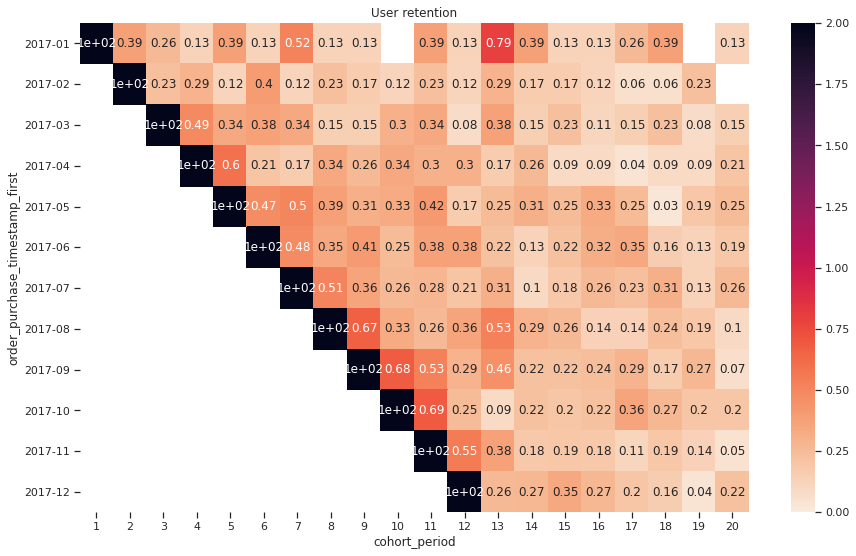

In [259]:
cmap = sns.cm.rocket_r
sns.set(style='ticks')
plt.figure(figsize=(15, 9))
plt.xlabel('Cohorts')
plt.title('User retention')
sns.heatmap(table, annot=True, cmap=cmap, vmin=0, vmax=2, center= 1)

Необходимо найти когорту с самым высоким retention на 3й месяц

In [257]:
max_crr=cohorts.copy()
max_crr.reset_index(inplace=True)

sp1, sp2=[], []
for i, row in max_crr.iterrows():
    coh=int(row['order_purchase_timestamp_first'].split('-')[1])
    if row['cohort_period']==(coh+3):
        sp1.append(row['order_purchase_timestamp_first'])
        sp2.append(row['CRR'])

In [258]:
df=pd.DataFrame({'coh': sp1, 'CRR': sp2})
df.loc[df['CRR'].idxmax()]

coh    2017-06
CRR       0.41
Name: 5, dtype: object

Когорта с самым высоким retention на 3й месяц (0.41) у покупателей, сделавших покупку 2017-06

## 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Мерджим удобный для работы датафрейм, оставляем только оплаченные заказы с корректными статусами, удаляем лишние пропуски.

In [220]:
orders_items=customer.merge(orders, on='customer_id', how='left').merge(order_items, on='order_id', how='left') \
    .dropna(subset=['order_approved_at']) \
    .query('order_status != "approved"') \
    .dropna(axis='index', how='any', subset=['order_purchase_timestamp'])
orders_items.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79


Приводим колонку с датой заказа к формату datetime

In [221]:
orders_items.order_purchase_timestamp = pd.to_datetime(orders_items.order_purchase_timestamp)

Оставляем только нужные для работы колонки

In [222]:
orders_items = orders_items[{'order_id', 'order_purchase_timestamp', 'customer_unique_id','price','order_item_id'}]

In [223]:
orders_items.head(3)

,order_id,price,order_purchase_timestamp,customer_unique_id,order_item_id
0,00e7ee1b050b8499577073aeb2a297a1,124.99,2017-05-16 15:05:35,861eff4711a542e4b93843c6dd7febb0,1.0
1,29150127e6685892b6eab3eec79f59c7,289.00,2018-01-12 20:48:24,290c77bc529b7ac935b93aa66c333dc3,1.0
2,b2059ed67ce144a36e2aa97d2c9e9ad2,139.94,2018-05-19 16:07:45,060e732b5b29e8181a18229c7b0b2b5e,1.0


Проверяем временные рамки данных

In [224]:
print('Orders from {} to {}'.format(orders_items['order_purchase_timestamp'].min(),
                                    orders_items['order_purchase_timestamp'].max()))

Orders from 2016-09-04 21:15:19 to 2018-09-03 09:06:57


У нас есть данные о продажах за два года (с сентября 2016 г. по август 2018 г.). 
Обычнодля RFM-анализа используется один год. 
Я буду использовать 2017 год, так как он у нас полный.

Моделируем анализ в реальном времени в реальном времени, установив дату NOW на один день после последней покупки. Эта дата будет использоваться в качестве ориентира для расчета Recency очков.

In [225]:
NOW = orders_items['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 09:06:57')

Изучаем данные за один год. создаем period переменную на 365 (дней).

In [226]:
period = 365

Чтобы упростить задачу, добавляем столбец с количеством дней между покупкой и текущим моментом. Чтобы найти значения недавности, находим минимум этого столбца для каждого клиента.

In [227]:
orders_items['DaysSinceOrder'] = orders_items['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)

Для подсчета суммы покупок за все время Monetary нам понадобится стоимость заказов, поэтому добавляем столбец со стоимостью в наш датафрейм

In [228]:
orders_items['order_cost'] = orders_items.price * orders_items.order_item_id

Сгруппируем данные по клиентам и посчитаем Recency, Frequency и Monetary

In [229]:
rfm = orders_items.groupby('customer_unique_id', as_index=False)  \
            .agg({'DaysSinceOrder':'min',  \
                  'order_purchase_timestamp': 'count',  \
                 'order_cost':'sum'})

Переименуем полученные колонки

In [230]:
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_purchase_timestamp': 'Frequency', 'order_cost':'Monetary'}, inplace=True)

In [231]:
rfm.head(10)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
5,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00
6,00050ab1314c0e55a6ca13cf7181fecf,136,1,27.99
7,00053a61a98854899e70ed204dd4bafe,187,2,573.00
8,0005e1862207bf6ccc02e4228effd9a0,548,1,135.00
9,0005ef4cd20d2893f0d9fbd94d3c0d97,175,1,104.90


Вычислите значения R, F и M
На данный момент у меня есть значения для параметров Recency, Frequency и Monetary. Каждый клиент получит примечание от 1 до 5 для каждого параметра.
Мы можем сделать это, установив диапазоны, основанные на ожидаемом поведении. Например, чтобы оценить новизну, мы могли бы использовать такую шкалу:

1: 0-30 дней

2: 31-60 дней

3: 61-90 дней

4: 91-180 дней

5: 181-365 дней

Мы могли бы также использовать квинтили. Каждый квинтил содержит 20% населения. Использование квинтилей является более гибким, поскольку диапазоны будут адаптироваться к данным и будут работать в разных отраслях или если произойдет какое-либо изменение в ожидаемом поведении клиентов.
Я собираюсь использовать метод квинтилей. Сначала я получаю квинтили для каждого параметра.

In [232]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 98.0, 0.4: 183.0, 0.6: 274.0, 0.8: 389.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 114.9, 0.8: 195.0}}

Пишем методы для присвоения рангов от 1 до 5. Меньшее значение новизны лучше, тогда как более высокая частота и денежные значения лучше. 
Нам необходимо написать два отдельных метода.

In [233]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

Мы готовы получить оценки R, F и M каждого клиента.

In [234]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

Наконец, объединяем оценки R, F и M в RFM Score.

In [235]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,4,214


Оценки RFM дают нам 53
 = 125 сегментов. Работать с которыми непросто.
Мы будем работать с 10 сегментами на основе оценок R и F. Вот описание сегментов:

Немного информации о значения RFM:
Аббревиатура RFM расшифровывается:
- Recency — давность (как давно ваши пользователи что-то у вас покупали);
- Frequency — частота (как часто они у вас покупают);
- Monetary — деньги (общая сумма покупок). 


Сегментация - Описание

Champions -	Купил недавно, покупаю часто и трачу больше всего

Loyal Customers - клиенты	Совершайте покупки на регулярной основе. Реагируйте на рекламные акции.

Potential Loyalist - Недавние клиенты со средней частотой.

Recent Customers - Покупался совсем недавно, но не часто.

Promising - Недавно покупал, но потратил немного.

Customers Needing Attention	- Новизна, частота и денежные показатели выше среднего. Возможно, вы приобрели его не совсем недавно.

About To Sleep - Новизна и частота ниже среднего. Они будут потеряны, если не будут активированы повторно.

At Risk	- Приобретались часто, но очень давно. Нужно вернуть их обратно!

Can’t Lose Them	- Раньше часто совершал покупки, но долгое время не возвращался.

Hibernating - Последняя покупка была совершена давно и количество заказов было низким. Может быть потеряно.

In [236]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,4,214,hibernating


Теперь, когда у нас есть результаты, мы можем выполнить некоторую визуализацию данных, чтобы получить лучшее представление о  наших клиентах. Сначала давайте посмотрим на распределение R, F и M.

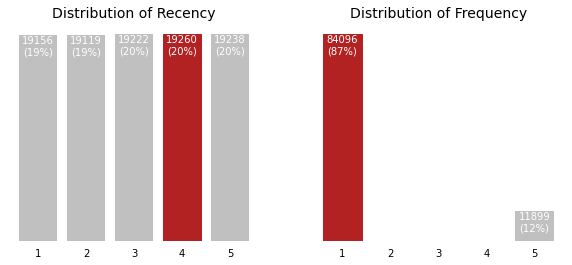

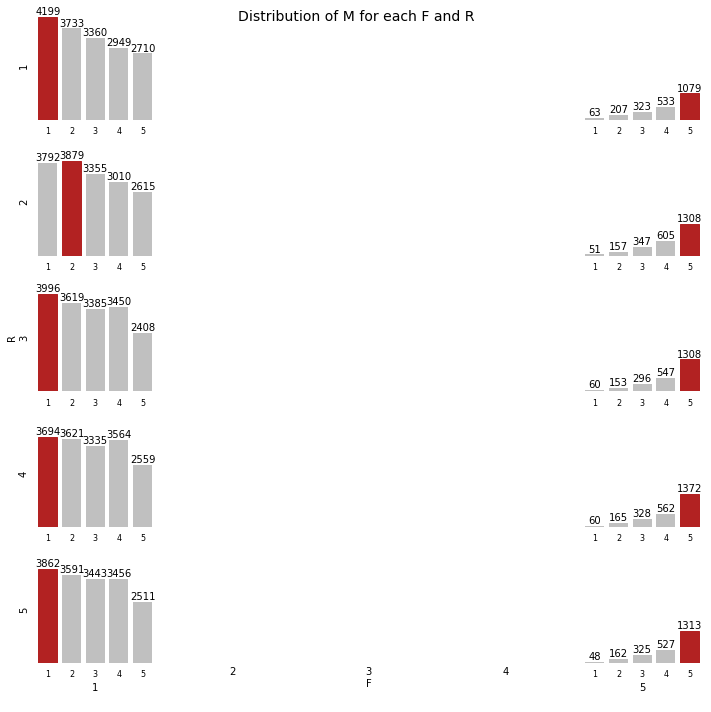

In [237]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

Мы можем видеть, что, если недавность покупок равномерно распределена, 87% покупателей совершает покупки очень редко(частота 1).
Если посмотреть на денежную оценку, мы видим, что она распределена равномерно между всеми группами.

Давайте посмотрим на распределение наших сегментов.
Для этого хорошо подходят столбчатые диаграммы.

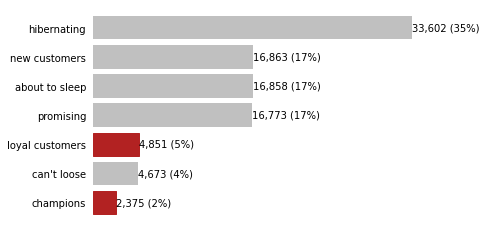

In [238]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

У нас много клиентов, которые нечасто совершают у нас покупки (33,6% в режиме Hibernating - Последняя покупка была совершена давно и количество заказов было низким. Может быть потеряно). Приблизительно 16,8 % наших клиентов являются либо новыми клиентами, либо теми, кто недавно покупал, но потратил немного, либо со статусом About To Sleep - новизна и частота ниже среднего. Максимально лояльные категории клиентов, такие как Champions, Can't lose и Loyal customers составляют в совокупности 11,9%, что является нормальным показателем для бизнеса.